# **Практика 3**

In [5]:
import os
import re
import warnings
from collections import Counter
import requests
from bs4 import BeautifulSoup
import time

import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

warnings.filterwarnings("ignore")

# Настройка стилей для визуализации
plt.style.use('default')
sns.set_palette("husl")
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD', '#98D8C8', '#F7DC6F', '#BB8FCE', '#85C1E9']

In [6]:
# Загрузка данных NLTK
print("Загрузка ресурсов NLTK...")
resources = ['punkt', 'stopwords', 'wordnet', 'punkt_tab', 'averaged_perceptron_tagger']
for resource in resources:
    try:
        if resource in ['punkt', 'punkt_tab']:
            nltk.data.find(f'tokenizers/{resource}')
        else:
            nltk.data.find(f'corpora/{resource}')
    except LookupError:
        nltk.download(resource)
        print(f"Загружено: {resource}")

Загрузка ресурсов NLTK...
Загружено: wordnet
Загружено: averaged_perceptron_tagger


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [7]:
# Функция парсинга текста с веб-страницы по URL
def parse_text_from_url(url):
    try:
        if pd.isna(url) or not isinstance(url, str) or not url.startswith(('http://', 'https://')):
            return ''

        print(f"Парсинг URL: {url}...")

        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        }

        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()

        soup = BeautifulSoup(response.content, 'html.parser')

        for script in soup(["script", "style", "nav", "footer", "header"]):
            script.decompose()

        text_elements = soup.find_all(['p', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'article', 'div'])

        all_text = []
        for element in text_elements:
            text = element.get_text().strip()
            if text and len(text) > 20:
                all_text.append(text)

        full_text = ' '.join(all_text)
        full_text = re.sub(r'\s+', ' ', full_text).strip()

        time.sleep(1)

        return full_text if full_text else ''

    except requests.exceptions.RequestException as e:
        print(f"Ошибка запроса для {url}: {e}")
        return ''
    except Exception as e:
        print(f"Ошибка парсинга для {url}: {e}")
        return ''

In [10]:
# Загрузка данных
all_data = pd.read_csv('news_data.csv')
all_data

,source_api,category,source_id,source_name,author,title,description,url,image_url,published_at,content,collected_at
0,newsapi.org,crypto,NaN,CoinDesk,"Siamak Masnavi, AI Boost",Ripple CLO Rejects the Narrative That Crypto I...,"Ripple's top lawyer, Stuart Alderoty, explains...",https://www.coindesk.com/policy/2025/10/18/rip...,https://cdn.sanity.io/images/s3y3vcno/producti...,2025-10-18 18:05:56+00:00,Cryptos latest media dust-up is missing the ev...,2025-10-19T21:10:32.632758
1,newsapi.org,crypto,NaN,Cointelegraph,Cointelegraph by Vince Quill,Stablecoins are really 'central business digit...,Privately-issued stablecoins feature the same ...,https://cointelegraph.com/news/stablecoins-cen...,https://images.cointelegraph.com/cdn-cgi/image...,2025-10-18 17:58:43+00:00,Investors should exercise discernment when con...,2025-10-19T21:10:32.632758
2,newsapi.org,sports,espn,ESPN,Laurence Edmondson,Verstappen wins chaotic Austin sprint race,Max Verstappen's championship chances received...,https://www.espn.com/f1/story/_/id/46603579/ma...,https://a2.espncdn.com/combiner/i?img=%2Fphoto...,2025-10-18 17:56:10+00:00,"AUSTIN, Texas -- Max Verstappen's championship...",2025-10-19T21:10:11.318711
3,newsapi.org,crypto,NaN,CoinDesk,Aoyon Ashraf,"'Great Hackers, Terrible Traders': How Exploit...",Six hacker wallets dumped ETH during the Oct. ...,https://www.coindesk.com/markets/2025/10/18/gr...,https://cdn.sanity.io/images/s3y3vcno/producti...,2025-10-18 17:38:09+00:00,Last week's massive crypto crash didnt just hi...,2025-10-19T21:10:32.632758
4,newsapi.org,crypto,NaN,CoinDesk,Stephen Alpher,'Deploying More Capital — Steady Lads': Bitcoi...,Already losing favor with investors when bitco...,https://www.coindesk.com/markets/2025/10/18/de...,https://cdn.sanity.io/images/s3y3vcno/producti...,2025-10-18 17:00:00+00:00,Is crypto winter coming? It's already more tha...,2025-10-19T21:10:32.632758
...,...,...,...,...,...,...,...,...,...,...,...,...
456,newsapi.org,ai,NaN,Arxiv.org,derekhecksher,Supporting Our AI Overlords: Redesigning Data ...,"Large Language Model (LLM) agents, acting on t...",https://arxiv.org/abs/2509.00997,https://arxiv.org/static/browse/0.3.4/images/a...,2025-09-20 03:41:23+00:00,arXivLabs is a framework that allows collabora...,2025-10-19T21:10:28.609629
457,newsapi.org,health,NaN,WebMD,Alicia Gallegos,"Weird, Wacky Side Effects of Weight Loss",A family doctor and obesity specialist talks a...,https://www.webmd.com/obesity/features/weird-w...,https://img.lb.wbmdstatic.com/vim/live/webmd/c...,2025-09-19 23:39:10+00:00,"If you're on a weight loss journey, you're pro...",2025-10-19T21:10:15.130640
458,newsapi.org,health,NaN,World Health Organization,World Health Organization: WHO,Amended International Health Regulations enter...,<p>Today marks a milestone in global health go...,https://www.who.int/news/item/19-09-2025-amend...,https://cdn.who.int/media/images/default-sourc...,2025-09-19 17:45:27+00:00,Today marks a milestone in global health gover...,2025-10-19T21:10:15.130640
459,newsapi.org,travel,NaN,Travel+Leisure,Staff Author,Royal Caribbean Cancels All Stops to This Cari...,The cruise line paused all visits to Labadee a...,https://www.travelandleisure.com/royal-caribbe...,https://s.yimg.com/ny/api/res/1.2/CHPdOzcJe.y9...,2025-09-19 17:12:09+00:00,Royal Caribbean has extended its pause on sail...,2025-10-19T21:10:40.632053


In [11]:
text_column = 'content' if 'content' in all_data.columns else \
             ('text' if 'text' in all_data.columns else all_data.columns[0])
print(f"Используется колонка: '{text_column}'")

all_data[text_column] = all_data[text_column].fillna('')
all_data['combined_raw'] = all_data[text_column].astype(str)

Используется колонка: 'content'


In [43]:
all_data['content']

,content
0,Cryptos latest media dust-up is missing the ev...
1,Investors should exercise discernment when con...
2,"AUSTIN, Texas -- Max Verstappen's championship..."
3,Last week's massive crypto crash didnt just hi...
4,Is crypto winter coming? It's already more tha...
...,...
456,arXivLabs is a framework that allows collabora...
457,"If you're on a weight loss journey, you're pro..."
458,Today marks a milestone in global health gover...
459,Royal Caribbean has extended its pause on sail...


In [44]:
all_data['url']

,url
0,https://www.coindesk.com/policy/2025/10/18/rip...
1,https://cointelegraph.com/news/stablecoins-cen...
2,https://www.espn.com/f1/story/_/id/46603579/ma...
3,https://www.coindesk.com/markets/2025/10/18/gr...
4,https://www.coindesk.com/markets/2025/10/18/de...
...,...
456,https://arxiv.org/abs/2509.00997
457,https://www.webmd.com/obesity/features/weird-w...
458,https://www.who.int/news/item/19-09-2025-amend...
459,https://www.travelandleisure.com/royal-caribbe...


In [13]:
# Парсинг текста из URL

parsed_texts = []

for index, url in enumerate(all_data['url']):
    print(f"Парсинг {index + 1}/{len(all_data)}: {url}...")
    text = parse_text_from_url(url)
    parsed_texts.append(text)

    if (index + 1) % 10 == 0:
        print(f"Прогресс: {index + 1}/{len(all_data)} завершено")

all_data = all_data.head(len(parsed_texts)).copy()
all_data['parsed_content'] = parsed_texts

successful_parses = sum(1 for text in parsed_texts if text.strip())
print(f"\nУспешно распарсено: {successful_parses}/{len(parsed_texts)} URL")
print(f"Процент успеха: {successful_parses/len(parsed_texts)*100:.1f}%")

text_column = 'parsed_content'
print(f"Используется колонка: '{text_column}'")

Парсинг 1/461: https://www.coindesk.com/policy/2025/10/18/ripple-clo-rejects-the-narrative-that-crypto-is-just-a-tool-for-crime-and-corruption...
Парсинг URL: https://www.coindesk.com/policy/2025/10/18/ripple-clo-rejects-the-narrative-that-crypto-is-just-a-tool-for-crime-and-corruption...
Ошибка запроса для https://www.coindesk.com/policy/2025/10/18/ripple-clo-rejects-the-narrative-that-crypto-is-just-a-tool-for-crime-and-corruption: 429 Client Error: Too Many Requests for url: https://www.coindesk.com/policy/2025/10/18/ripple-clo-rejects-the-narrative-that-crypto-is-just-a-tool-for-crime-and-corruption
Парсинг 2/461: https://cointelegraph.com/news/stablecoins-central-business-digital-currencies...
Парсинг URL: https://cointelegraph.com/news/stablecoins-central-business-digital-currencies...
Парсинг 3/461: https://www.espn.com/f1/story/_/id/46603579/max-verstappen-wins-chaotic-us-gp-sprint-mclarens-crash-out...
Парсинг URL: https://www.espn.com/f1/story/_/id/46603579/max-verstappen-win

In [15]:
all_data[text_column] = all_data[text_column].fillna('')
all_data['combined_raw'] = all_data[text_column].astype(str)

In [16]:
# Инициализация инструментов NLP
try:
    stop_words = set(stopwords.words('english'))
except:
    stop_words = set()

lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Регулярные выражения для очистки
URL = re.compile(r'https?://\S+|www\.\S+')
HTML = re.compile(r'<[^>]+>')
MENTION_HASHTAG = re.compile(r'[@#]\w+')
EMOJI = re.compile(
    "["u"\U0001F600-\U0001F64F"
    u"\U0001F300-\U0001F5FF"
    u"\U0001F680-\U0001F6FF"
    u"\U00002600-\U000026FF"
    u"\U00002700-\U000027BF"
    "]+", flags=re.UNICODE)
ALPHANUMERIC = re.compile(r'[^0-9A-Za-z\s\-]')

In [17]:
# Предобработка данных

processed_texts = []
sentence_lists = []
token_lists = []
sentiment_labels = []
sentiment_scores_list = []
entity_records = []

for doc_index, raw_text in enumerate(all_data['combined_raw']):
    print(f"Обработка документа {doc_index + 1}/{len(all_data)}...")

    try:
        # 1. Очистка текста
        if pd.isna(raw_text):
            cleaned_text = ''
        else:
            text_string = str(raw_text)
            text_string = URL.sub(' ', text_string)
            text_string = HTML.sub(' ', text_string)
            text_string = EMOJI.sub(' ', text_string)
            text_string = MENTION_HASHTAG.sub(' ', text_string)
            text_string = ALPHANUMERIC.sub(' ', text_string)
            text_string = re.sub(r'\d+', ' ', text_string)
            text_string = re.sub(r'\s+', ' ', text_string).strip()
            cleaned_text = text_string

        # 2. Токенизация
        if not cleaned_text:
            sentences = []
            tokens = []
        else:
            sentences = sent_tokenize(cleaned_text, language='english')
            tokens = word_tokenize(cleaned_text, language='english')

        # 3. Нормализация
        normalized_tokens = []
        for token in tokens:
            processed_token = token.lower().strip()

            if not processed_token or processed_token in stop_words or len(processed_token) <= 2:
                continue

            processed_token = lemmatizer.lemmatize(processed_token)
            processed_token = stemmer.stem(processed_token)

            if processed_token and len(processed_token) > 1:
                normalized_tokens.append(processed_token)

        processed_text = ' '.join(normalized_tokens)

        processed_texts.append(processed_text)
        sentence_lists.append(sentences)
        token_lists.append(normalized_tokens)

        # 4. Анализ тональности
        if not raw_text or str(raw_text).strip() == '':
            sentiment_label = 'neutral'
            sentiment_score = 0.0
        else:
            text_lower = raw_text.lower()
            positive_words = ['good', 'great', 'excellent', 'amazing', 'wonderful', 'best', 'love', 'like', 'positive']
            negative_words = ['bad', 'terrible', 'awful', 'horrible', 'worst', 'hate', 'dislike', 'negative']

            positive_count = sum(1 for word in positive_words if word in text_lower)
            negative_count = sum(1 for word in negative_words if word in text_lower)

            total = positive_count + negative_count
            if total == 0:
                sentiment_label = 'neutral'
                sentiment_score = 0.0
            elif positive_count > negative_count:
                sentiment_score = positive_count / total
                sentiment_label = 'positive'
            elif negative_count > positive_count:
                sentiment_score = negative_count / total
                sentiment_label = 'negative'
            else:
                sentiment_label = 'neutral'
                sentiment_score = 0.0

        sentiment_labels.append(sentiment_label)
        sentiment_scores_list.append(sentiment_score)

        # 5. Извлечение сущностей
        entities = {'PERSON': [], 'ORG': [], 'DATE': [], 'GPE': []}

        if raw_text:
            words = str(raw_text).split()

            for word in words:
                if re.match(r'\d{1,2}[./-]\d{1,2}[./-]\d{2,4}', word) or re.match(r'\d{4}-\d{2}-\d{2}', word):
                    entities['DATE'].append(word)
                elif word.istitle() and len(word) > 2:
                    if word.lower() not in ['the', 'and', 'for', 'with']:
                        entities['ORG'].append(word)

            for key in entities:
                entities[key] = list(set(entities[key]))[:5]

        entity_records.append({
            'doc_id': doc_index,
            'persons': '; '.join(entities.get('PERSON', [])),
            'orgs': '; '.join(entities.get('ORG', [])),
            'dates': '; '.join(entities.get('DATE', [])),
            'locations': '; '.join(entities.get('GPE', []))
        })

    except Exception as error:
        print(f"Ошибка при обработке документа {doc_index}: {error}")
        processed_texts.append('')
        sentence_lists.append([])
        token_lists.append([])
        sentiment_labels.append('neutral')
        sentiment_scores_list.append(0.0)
        entity_records.append({
            'doc_id': doc_index,
            'persons': '', 'orgs': '', 'dates': '', 'locations': ''
        })

all_data['processed'] = processed_texts
all_data['sentences'] = sentence_lists
all_data['tokens'] = token_lists
all_data['sentiment'] = sentiment_labels
all_data['sentiment_score'] = sentiment_scores_list

Обработка документа 1/461...
Обработка документа 2/461...
Обработка документа 3/461...
Обработка документа 4/461...
Обработка документа 5/461...
Обработка документа 6/461...
Обработка документа 7/461...
Обработка документа 8/461...
Обработка документа 9/461...
Обработка документа 10/461...
Обработка документа 11/461...
Обработка документа 12/461...
Обработка документа 13/461...
Обработка документа 14/461...
Обработка документа 15/461...
Обработка документа 16/461...
Обработка документа 17/461...
Обработка документа 18/461...
Обработка документа 19/461...
Обработка документа 20/461...
Обработка документа 21/461...
Обработка документа 22/461...
Обработка документа 23/461...
Обработка документа 24/461...
Обработка документа 25/461...
Обработка документа 26/461...
Обработка документа 27/461...
Обработка документа 28/461...
Обработка документа 29/461...
Обработка документа 30/461...
Обработка документа 31/461...
Обработка документа 32/461...
Обработка документа 33/461...
Обработка документа

In [45]:
all_data

,source_api,category,source_id,source_name,author,title,description,url,image_url,published_at,...,collected_at,combined_raw,parsed_content,processed,sentences,tokens,sentiment,sentiment_score,predicted_category,category_confidence
0,newsapi.org,crypto,NaN,CoinDesk,"Siamak Masnavi, AI Boost",Ripple CLO Rejects the Narrative That Crypto I...,"Ripple's top lawyer, Stuart Alderoty, explains...",https://www.coindesk.com/policy/2025/10/18/rip...,https://cdn.sanity.io/images/s3y3vcno/producti...,2025-10-18 18:05:56+00:00,...,2025-10-19T21:10:32.632758,,,,[],[],neutral,0.000000,other,0.000
1,newsapi.org,crypto,NaN,Cointelegraph,Cointelegraph by Vince Quill,Stablecoins are really 'central business digit...,Privately-issued stablecoins feature the same ...,https://cointelegraph.com/news/stablecoins-cen...,https://images.cointelegraph.com/cdn-cgi/image...,2025-10-18 17:58:43+00:00,...,2025-10-19T21:10:32.632758,"Vince Quill Oct 18, 2025 Stablecoins are reall...","Vince Quill Oct 18, 2025 Stablecoins are reall...",vinc quill oct stablecoin realli central busi ...,[Vince Quill Oct Stablecoins are really centra...,"[vinc, quill, oct, stablecoin, realli, central...",positive,0.666667,crypto,0.226
2,newsapi.org,sports,espn,ESPN,Laurence Edmondson,Verstappen wins chaotic Austin sprint race,Max Verstappen's championship chances received...,https://www.espn.com/f1/story/_/id/46603579/ma...,https://a2.espncdn.com/combiner/i?img=%2Fphoto...,2025-10-18 17:56:10+00:00,...,2025-10-19T21:10:11.318711,Skip to main content Skip to navigation < > Ve...,Skip to main content Skip to navigation < > Ve...,skip main content skip navig verstappen win ch...,[Skip to main content Skip to navigation Verst...,"[skip, main, content, skip, navig, verstappen,...",positive,0.666667,sports,0.235
3,newsapi.org,crypto,NaN,CoinDesk,Aoyon Ashraf,"'Great Hackers, Terrible Traders': How Exploit...",Six hacker wallets dumped ETH during the Oct. ...,https://www.coindesk.com/markets/2025/10/18/gr...,https://cdn.sanity.io/images/s3y3vcno/producti...,2025-10-18 17:38:09+00:00,...,2025-10-19T21:10:32.632758,,,,[],[],neutral,0.000000,other,0.000
4,newsapi.org,crypto,NaN,CoinDesk,Stephen Alpher,'Deploying More Capital — Steady Lads': Bitcoi...,Already losing favor with investors when bitco...,https://www.coindesk.com/markets/2025/10/18/de...,https://cdn.sanity.io/images/s3y3vcno/producti...,2025-10-18 17:00:00+00:00,...,2025-10-19T21:10:32.632758,,,,[],[],neutral,0.000000,other,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456,newsapi.org,ai,NaN,Arxiv.org,derekhecksher,Supporting Our AI Overlords: Redesigning Data ...,"Large Language Model (LLM) agents, acting on t...",https://arxiv.org/abs/2509.00997,https://arxiv.org/static/browse/0.3.4/images/a...,2025-09-20 03:41:23+00:00,...,2025-10-19T21:10:28.609629,Happy Open Access Week from arXiv! YOU make op...,Happy Open Access Week from arXiv! YOU make op...,happi open access week arxiv make open access ...,[Happy Open Access Week from arXiv YOU make op...,"[happi, open, access, week, arxiv, make, open,...",positive,1.000000,science,0.190
457,newsapi.org,health,NaN,WebMD,Alicia Gallegos,"Weird, Wacky Side Effects of Weight Loss",A family doctor and obesity specialist talks a...,https://www.webmd.com/obesity/features/weird-w...,https://img.lb.wbmdstatic.com/vim/live/webmd/c...,2025-09-19 23:39:10+00:00,...,2025-10-19T21:10:15.130640,Weight Loss & ObesityFeature StoriesWeight Los...,Weight Loss & ObesityFeature StoriesWeight Los...,weight loss obesityfeatur storiesweight loss o...,[Weight Loss ObesityFeature StoriesWeight Loss...,"[weight, loss, obesityfeatur, storiesweight, l...",positive,1.000000,health,0.240
458,newsapi.org,health,NaN,World Health Organization,World Health Organization: WHO,Amended International Health Regulations enter...,<p>Today marks a milestone in global health go...,https://www.who.int/news/item/19-09-2025-amend...,https://cdn.who.int/media/images/default-sourc...,

In [18]:
# Частотный анализ

all_words = []
for text in processed_texts:
    if text:
        all_words.extend(text.split())

word_frequency = Counter(all_words)
top_20_words = word_frequency.most_common(20)

print("1. Топ-20 частых слов:")
for position, (word, frequency) in enumerate(top_20_words, 1):
    print(f"    {position}. {word} — {frequency} раз")

1. Топ-20 частых слов:
    1. articl — 21188 раз
    2. new — 13736 раз
    3. restaur — 11477 раз
    4. like — 11266 раз
    5. one — 10938 раз
    6. googl — 10762 раз
    7. use — 10559 раз
    8. also — 9716 раз
    9. share — 9390 раз
    10. ago — 8770 раз
    11. pubm — 8634 раз
    12. time — 8576 раз
    13. data — 8552 раз
    14. read — 8323 раз
    15. work — 8224 раз
    16. year — 8181 раз
    17. said — 8130 раз
    18. get — 8119 раз
    19. scholar — 7310 раз
    20. week — 7276 раз


In [19]:
# Анализ тональности
print("2. Эмоциональная окраска текстов:")
sentiment_summary = all_data['sentiment'].value_counts().reset_index()
sentiment_summary.columns = ['sentiment', 'count']
for _, row in sentiment_summary.iterrows():
    print(f"    {row['sentiment']} — {row['count']} текстов")

2. Эмоциональная окраска текстов:
    positive — 356 текстов
    neutral — 102 текстов
    negative — 3 текстов


In [46]:
# Сущности
print("3. Ключевые сущности:")
entities_dataframe = pd.DataFrame(entity_records)
documents_to_show = min(3, len(entities_dataframe))

for doc_index in range(documents_to_show):
    entity_row = entities_dataframe.iloc[doc_index]
    print(f"Документ {doc_index + 1}:")

    if entity_row['persons']:
        print(f"  Люди: {entity_row['persons']}")
    if entity_row['orgs']:
        print(f"  Организации: {entity_row['orgs']}")
    if entity_row['locations']:
        print(f"  Места: {entity_row['locations']}")
    if entity_row['dates']:
        print(f"  Даты: {entity_row['dates']}")
    print()

3. Ключевые сущности:
Документ 1:

Документ 2:
  Организации: Global,; Patriot; Quill; Global; Jeremy

Документ 3:
  Организации: Lewis; Before; Sky; Ferraris; P3,



In [21]:
# Классификация по категориям
print("4. Классификация по категориям")

CATEGORY_KEYWORDS = {
    'sports': ['game', 'player', 'team', 'season', 'win', 'score', 'championship', 'match', 'league', 'tournament'],
    'technology': ['tech', 'software', 'digital', 'innovation', 'startup', 'computer', 'mobile', 'app', 'device'],
    'health': ['health', 'medical', 'doctor', 'hospital', 'disease', 'treatment', 'medicine', 'patient', 'care'],
    'business': ['business', 'market', 'company', 'investment', 'economic', 'profit', 'finance', 'stock', 'trade'],
    'science': ['science', 'research', 'study', 'scientist', 'discovery', 'experiment', 'theory', 'data'],
    'politics': ['politics', 'government', 'election', 'policy', 'minister', 'president', 'law', 'vote'],
    'music': ['music', 'song', 'album', 'artist', 'tour', 'concert', 'billboard', 'band', 'performance'],
    'environment': ['environment', 'climate', 'nature', 'eco', 'sustainable', 'green', 'planet', 'earth'],
    'entertainment': ['entertainment', 'movie', 'film', 'celebrity', 'hollywood', 'tv', 'show', 'actor'],
    'ai': ['ai', 'artificial', 'intelligence', 'machine', 'learning', 'neural', 'algorithm', 'model'],
    'cybersecurity': ['cybersecurity', 'security', 'hack', 'breach', 'malware', 'firewall', 'encryption'],
    'crypto': ['bitcoin', 'crypto', 'blockchain', 'token', 'defi', 'nft', 'ethereum', 'digital', 'currency'],
    'gaming': ['gaming', 'game', 'player', 'console', 'video', 'esports', 'stream', 'gamer'],
    'space': ['space', 'nasa', 'rocket', 'planet', 'orbit', 'satellite', 'universe', 'astronomy'],
    'fashion': ['fashion', 'designer', 'collection', 'runway', 'luxury', 'style', 'clothing', 'trend'],
    'travel': ['travel', 'trip', 'destination', 'hotel', 'flight', 'tourist', 'vacation', 'journey'],
    'food': ['food', 'restaurant', 'recipe', 'cooking', 'cuisine', 'dish', 'meal', 'culinary'],
    'books': ['book', 'author', 'novel', 'literature', 'publishing', 'reading', 'story', 'writer'],
    'wellness': ['wellness', 'health', 'fitness', 'yoga', 'meditation', 'mindfulness', 'selfcare'],
    'renewables': ['renewable', 'energy', 'solar', 'wind', 'green', 'sustainable', 'clean', 'power'],
    'edtech': ['edtech', 'education', 'learning', 'student', 'school', 'digital', 'online', 'course'],
    'robotics': ['robotics', 'robot', 'automation', 'ai', 'machine', 'autonomous', 'tech'],
    'philanthropy': ['philanthropy', 'charity', 'donation', 'nonprofit', 'foundation', 'give', 'support'],
    'other': []
}

predicted_categories = []
category_confidences = []

for text in all_data['combined_raw']:
    if not text or str(text).strip() == '':
        predicted_categories.append('other')
        category_confidences.append(0.0)
        continue

    text_lowercase = str(text).lower()
    category_scores = {}

    for category, keywords in CATEGORY_KEYWORDS.items():
        match_count = sum(1 for keyword in keywords if keyword.lower() in text_lowercase)
        category_scores[category] = match_count

    best_category = max(category_scores, key=category_scores.get)
    total_matches = sum(category_scores.values())

    confidence = (category_scores[best_category] / total_matches) if total_matches > 0 else 0.0

    if category_scores[best_category] == 0:
        predicted_categories.append('other')
        category_confidences.append(0.0)
    else:
        predicted_categories.append(best_category)
        category_confidences.append(round(confidence, 3))

all_data['predicted_category'] = predicted_categories
all_data['category_confidence'] = category_confidences

print("Категории текстов:")
category_counts = all_data['predicted_category'].value_counts()
for category, count in category_counts.items():
    print(f"    {category} — {count} текстов")

4. Классификация по категориям
Категории текстов:
    sports — 60 текстов
    other — 44 текстов
    health — 44 текстов
    technology — 37 текстов
    science — 31 текстов
    music — 30 текстов
    fashion — 29 текстов
    business — 26 текстов
    entertainment — 21 текстов
    environment — 20 текстов
    food — 20 текстов
    ai — 19 текстов
    space — 13 текстов
    gaming — 13 текстов
    books — 13 текстов
    crypto — 11 текстов
    renewables — 11 текстов
    politics — 6 текстов
    robotics — 5 текстов
    wellness — 4 текстов
    travel — 3 текстов
    edtech — 1 текстов


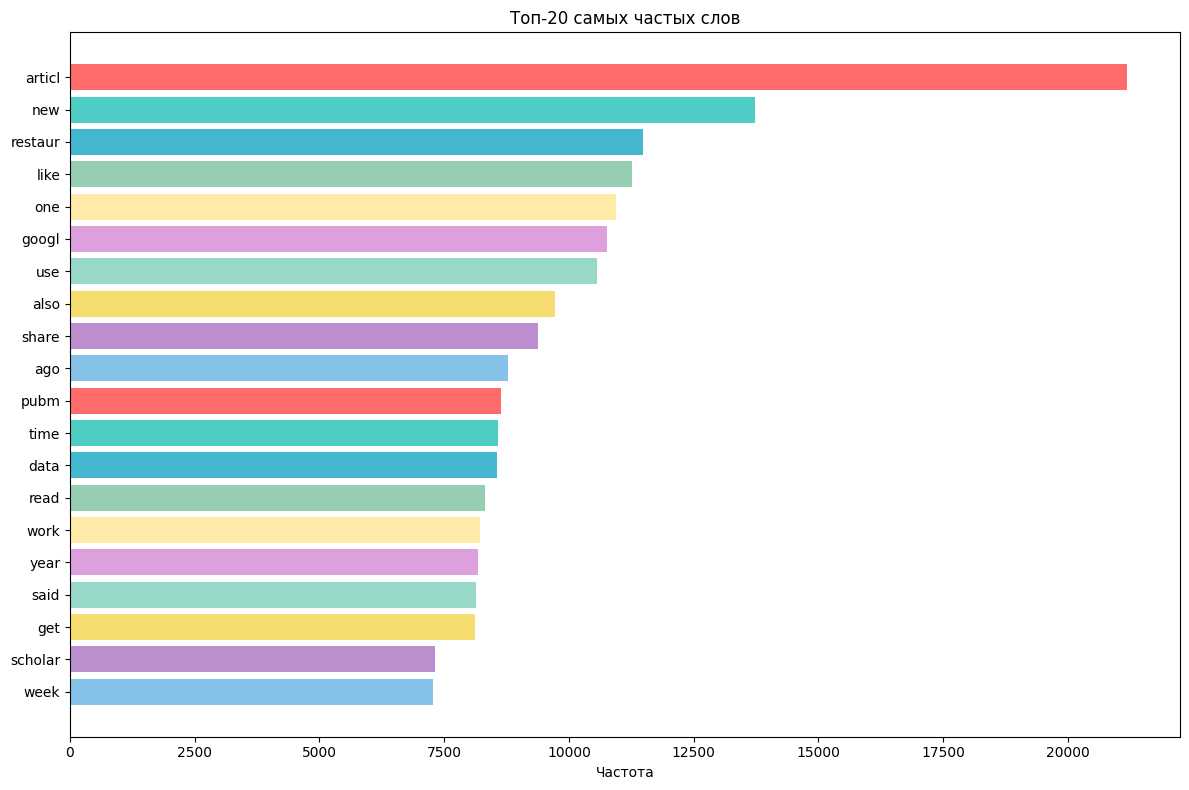

In [42]:
# 1. Визуализация топ-20 слов
words, counts = zip(*top_20_words)

plt.figure(figsize=(12, 8))

bars = plt.barh(words, counts, color=colors[:len(words)])
plt.xlabel('Частота')
plt.title('Топ-20 самых частых слов')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

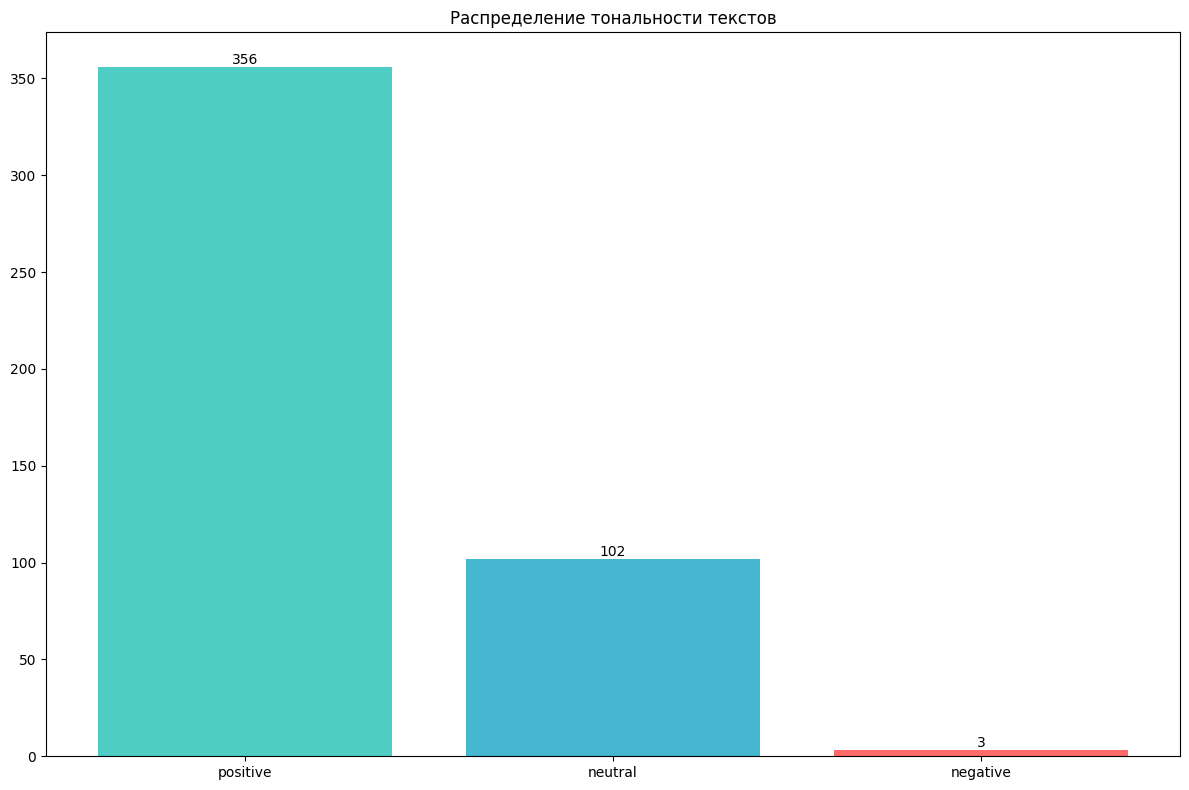

In [39]:
# 2. Визуализация тональности
sentiment_counts = all_data['sentiment'].value_counts()

plt.figure(figsize=(12, 8))

sentiment_colors = {'positive': '#4ECDC4', 'negative': '#FF6B6B', 'neutral': '#45B7D1'}
colors_list = [sentiment_colors.get(sent, '#96CEB4') for sent in sentiment_counts.index]

bars = plt.bar(sentiment_counts.index, sentiment_counts.values, color=colors_list)
plt.title('Распределение тональности текстов')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom')


plt.tight_layout()
plt.savefig('sentiment_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

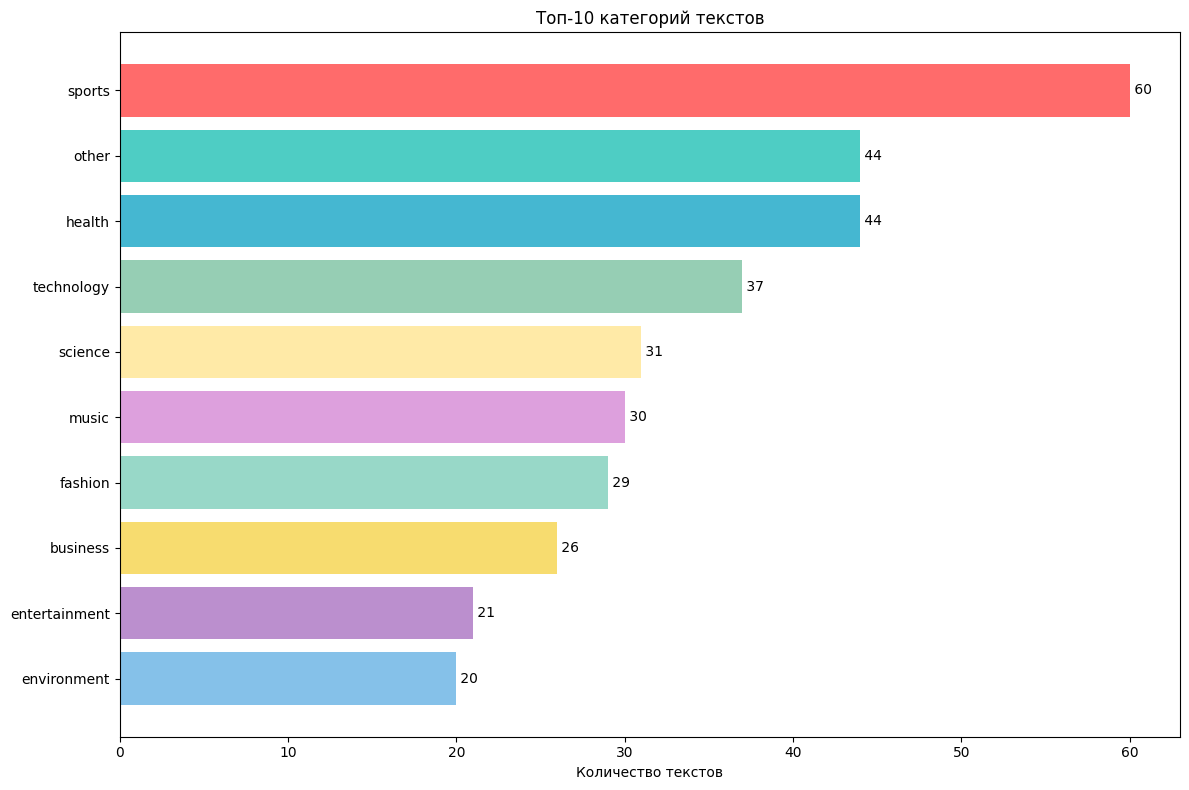

In [40]:
# 3. Визуализация категорий
category_counts = all_data['predicted_category'].value_counts().head(10)

plt.figure(figsize=(12, 8))
bars = plt.barh(category_counts.index, category_counts.values, color=colors)
plt.xlabel('Количество текстов')
plt.title('Топ-10 категорий текстов')
plt.gca().invert_yaxis()

for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2.,
            f' {int(width)}', va='center', ha='left')

plt.tight_layout()
plt.show()